<a href="https://colab.research.google.com/github/MariaGraziaBorzi/SER/blob/main/SER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
from IPython.display import Audio
import IPython.display as ipd
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix

# Esempio dati presenti in RAVDESS

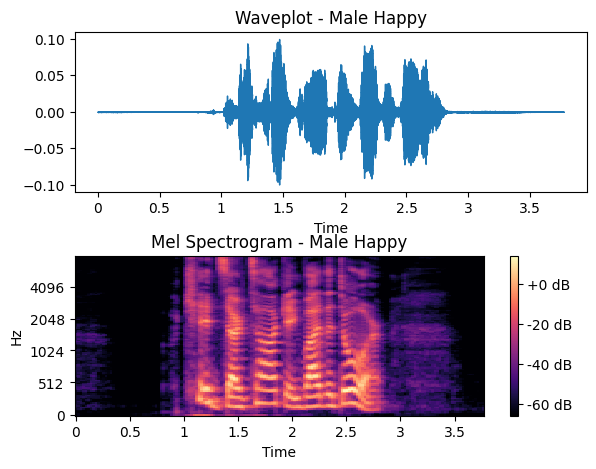

In [24]:
# LOAD IN FILE
x, sr = librosa.load('/content/Audio_Speech_Actors_01-24/Actor_03/03-01-03-01-01-01-03.wav')
# PLAY AUDIO FILE
wn = Audio('/content/Audio_Speech_Actors_01-24/Actor_03/03-01-03-01-01-01-03.wav', autoplay=True)
display(wn)
# DISPLAY WAVEPLOT
plt.subplot(2,1,1)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.4)
#plt.figure(figsize=(8, 4))
librosa.display.waveshow(x, sr=sr)
plt.title('Waveplot - Male Happy')

# CREATE LOG MEL SPECTROGRAM
x = librosa.feature.melspectrogram(y=x, sr=sr,n_mels=128,fmax=8000)
x = librosa.power_to_db(x)

plt.subplot(2,1,2)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.4)
librosa.display.specshow(x, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Male Happy')
plt.colorbar(format='%+2.0f dB');

plt.show()

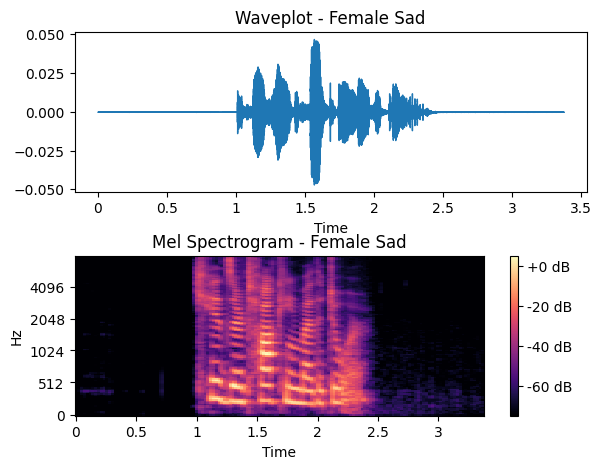

In [25]:
# LOAD FILE
x, sr = librosa.load('/content/Audio_Speech_Actors_01-24/Actor_04/03-01-04-01-01-01-04.wav')
# PLAY AUDIO FILE
wn = Audio('/content/Audio_Speech_Actors_01-24/Actor_04/03-01-04-01-01-01-04.wav', autoplay=True)
display(wn)
# DISPLAY WAVEPLOT
plt.subplot(2,1,1)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.4)
librosa.display.waveshow(x, sr=sr)
plt.title('Waveplot - Female Sad')

plt.subplot(2,1,2)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.4)
x = librosa.feature.melspectrogram(y=x, sr=sr,n_mels=128,fmax=8000)
y = librosa.power_to_db(x)

librosa.display.specshow(y, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Female Sad');
plt.colorbar(format='%+2.0f dB');

plt.show()

# Caricamento Dataset

In [2]:
# Estrazione file zip
import zipfile
with zipfile.ZipFile("Audio_Speech_Actors_01-24.zip", "r") as zip_ref:
    zip_ref.extractall("Audio_Speech_Actors_01-24")

ravdess_dir_list = os.listdir("Audio_Speech_Actors_01-24/")
emotion = []
path = []

for dir_actor in ravdess_dir_list:
    actor = os.listdir(f"Audio_Speech_Actors_01-24/{dir_actor}")
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        emotion.append(int(part[2]))
        path.append(f"Audio_Speech_Actors_01-24/{dir_actor}/{file}")

# Dataframe per le emozioni e i percorsi
emotion_df = pd.DataFrame(emotion, columns=['Emotions'])
path_df = pd.DataFrame(path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# Mappatura delle emozioni
Ravdess_df.Emotions.replace({
    1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad',
    5: 'angry', 6: 'fear', 7: 'disgust', 8: 'surprise'}, inplace=True)

Ravdess_df.to_csv("data.csv", index=False)

<ipython-input-2-9cfa5a83d19b>:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  Ravdess_df.Emotions.replace({


In [18]:
Ravdess_df.head()

,Emotions,Path
0,sad,Audio_Speech_Actors_01-24/Actor_21/03-01-04-01...
1,neutral,Audio_Speech_Actors_01-24/Actor_21/03-01-01-01...
2,disgust,Audio_Speech_Actors_01-24/Actor_21/03-01-07-01...
3,surprise,Audio_Speech_Actors_01-24/Actor_21/03-01-08-01...
4,angry,Audio_Speech_Actors_01-24/Actor_21/03-01-05-02...


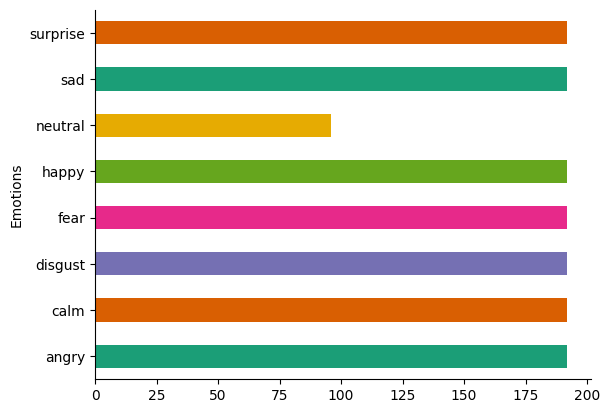

In [21]:
Ravdess_df.groupby('Emotions').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [3]:
# ------------------------ Estrazione delle feature ---------------------------
def extract_features(data):
    result = np.array([])
    sample_rate = 22050
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=13).T, axis=0)
    result = np.hstack((result, mfcc))
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))
    return result

def get_features(path):
    data, sampling_rate = librosa.load(path, offset=0.6, duration=2.5)

    res1 = extract_features(data)
    result = np.array(res1)

    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    noise_data = data + noise_amp * np.random.normal(size=data.shape[0])
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2))

    stretch_data = librosa.effects.time_stretch(data, rate=0.8)
    stretch_pitch_data = librosa.effects.pitch_shift(stretch_data, sr=sampling_rate, n_steps=1)
    res3 = extract_features(stretch_pitch_data)
    result = np.vstack((result, res3))

    return result

In [4]:
# ------------------------- Creazione dataset finale --------------------------
def dataset():
    X, Y = [], []
    data_path = pd.read_csv("data.csv")

    for path, emotion in zip(data_path.Path, data_path.Emotions):
        feature = get_features(path)
        for element in feature:
            X.append(element)
            Y.append(emotion)

    X = np.array(X)
    Y = np.array(Y)
    return X, Y

X, Y = dataset()

In [5]:
# --------------------------- Preprocessing dati ------------------------------
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1, 1)).toarray()

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=0, shuffle=True)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=0, shuffle=True)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)

x_train = np.expand_dims(x_train, axis=1)
x_test = np.expand_dims(x_test, axis=1)
x_val = np.expand_dims(x_val, axis=1)

In [10]:
# ------------------------ Definizione del modello PyTorch ---------------------
class EmotionModel(nn.Module):
    def __init__(self):
        super(EmotionModel, self).__init__()
        self.conv1 = nn.Conv1d(1, 256, kernel_size=8, padding='same')
        self.bn1 = nn.BatchNorm1d(256)
        self.conv2 = nn.Conv1d(256, 256, kernel_size=8, padding='same')
        self.conv3 = nn.Conv1d(256, 128, kernel_size=8, padding='same')
        self.conv4 = nn.Conv1d(128, 128, kernel_size=8, padding='same')
        self.conv5 = nn.Conv1d(128, 128, kernel_size=8, padding='same')
        self.conv6 = nn.Conv1d(128, 64, kernel_size=8, padding='same')
        self.bn2 = nn.BatchNorm1d(64)
        self.conv7 = nn.Conv1d(64, 64, kernel_size=8, padding='same')
        self.pool = nn.MaxPool1d(kernel_size=8)
        self.dropout = nn.Dropout(0.25)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128, 8)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.dropout(torch.relu(self.bn1(self.conv2(x))))
        x = self.pool(x)

        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = torch.relu(self.conv5(x))

        x = self.dropout(torch.relu(self.bn2(self.conv6(x))))
        x = self.pool(x)

        x = torch.relu(self.conv7(x))
        x = self.flatten(x)
        x = self.fc(x)
        return self.softmax(x)

In [16]:
# -------------------------- Addestramento del modello -------------------------
model = EmotionModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.00001, weight_decay=1e-6)

# DataLoader per PyTorch
train_loader = DataLoader(TensorDataset(torch.tensor(x_train).float(), torch.tensor(np.argmax(y_train, axis=1)).long()), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(torch.tensor(x_val).float(), torch.tensor(np.argmax(y_val, axis=1)).long()), batch_size=64, shuffle=False)

epochs = 100
#--------------
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
#----------------

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    #--------------
    correct_train = 0
    total_train = 0
    #-----------------
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        #------------------------
        # Track accuracy for training set
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        #-----------------------

    #Validation
    model.eval()
    val_loss = 0.0
    #-----------
    correct_val = 0
    total_val = 0
    #-----------
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            #----------------
            # Track accuracy for validation set
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            #---------------------
    #-------------------------------------
    # Calculate and store metrics
    train_losses.append(train_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))
    train_accuracies.append(100 * correct_train / total_train)
    val_accuracies.append(100 * correct_val / total_val)
    #-----------------------------------
    #print(f"Epoch {epoch+1}, Training Loss: {train_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}")
    print(f"Epoch {epoch+1}, Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, "
          f"Training Accuracy: {train_accuracies[-1]:.2f}%, Validation Accuracy: {val_accuracies[-1]:.2f}%")

Epoch 1, Training Loss: 2.0549, Validation Loss: 2.0716, Training Accuracy: 18.55%, Validation Accuracy: 20.37%
Epoch 2, Training Loss: 2.0393, Validation Loss: 2.0476, Training Accuracy: 24.11%, Validation Accuracy: 24.69%
Epoch 3, Training Loss: 2.0288, Validation Loss: 2.0390, Training Accuracy: 27.45%, Validation Accuracy: 22.69%
Epoch 4, Training Loss: 2.0216, Validation Loss: 2.0354, Training Accuracy: 26.92%, Validation Accuracy: 24.69%
Epoch 5, Training Loss: 2.0140, Validation Loss: 2.0310, Training Accuracy: 28.14%, Validation Accuracy: 24.38%
Epoch 6, Training Loss: 2.0072, Validation Loss: 2.0300, Training Accuracy: 27.91%, Validation Accuracy: 25.46%
Epoch 7, Training Loss: 1.9985, Validation Loss: 2.0254, Training Accuracy: 28.84%, Validation Accuracy: 25.46%
Epoch 8, Training Loss: 1.9910, Validation Loss: 2.0222, Training Accuracy: 28.94%, Validation Accuracy: 25.93%
Epoch 9, Training Loss: 1.9835, Validation Loss: 2.0183, Training Accuracy: 29.86%, Validation Accuracy:

Accuracy of the model on test data: 56.32716049382716%


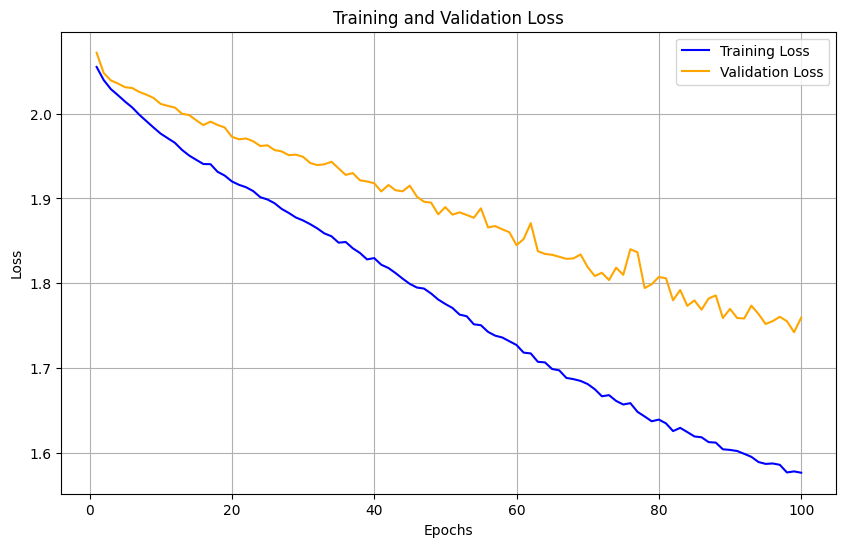

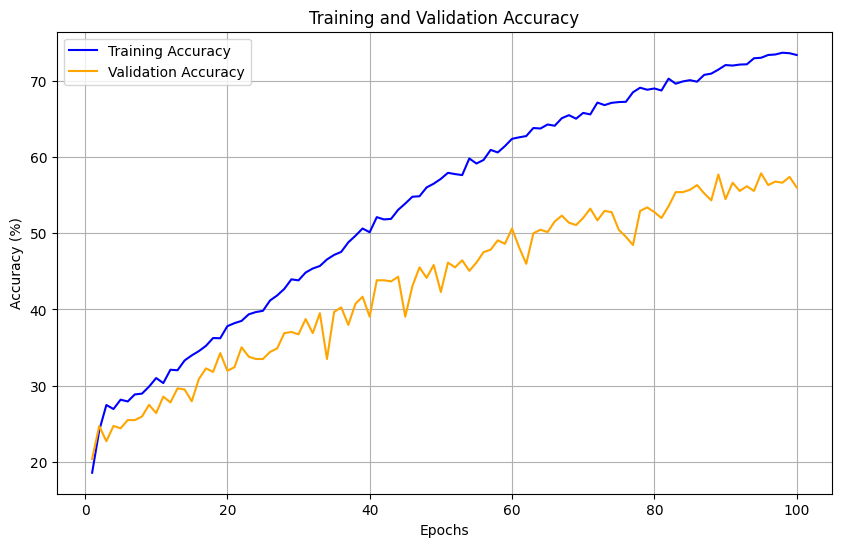

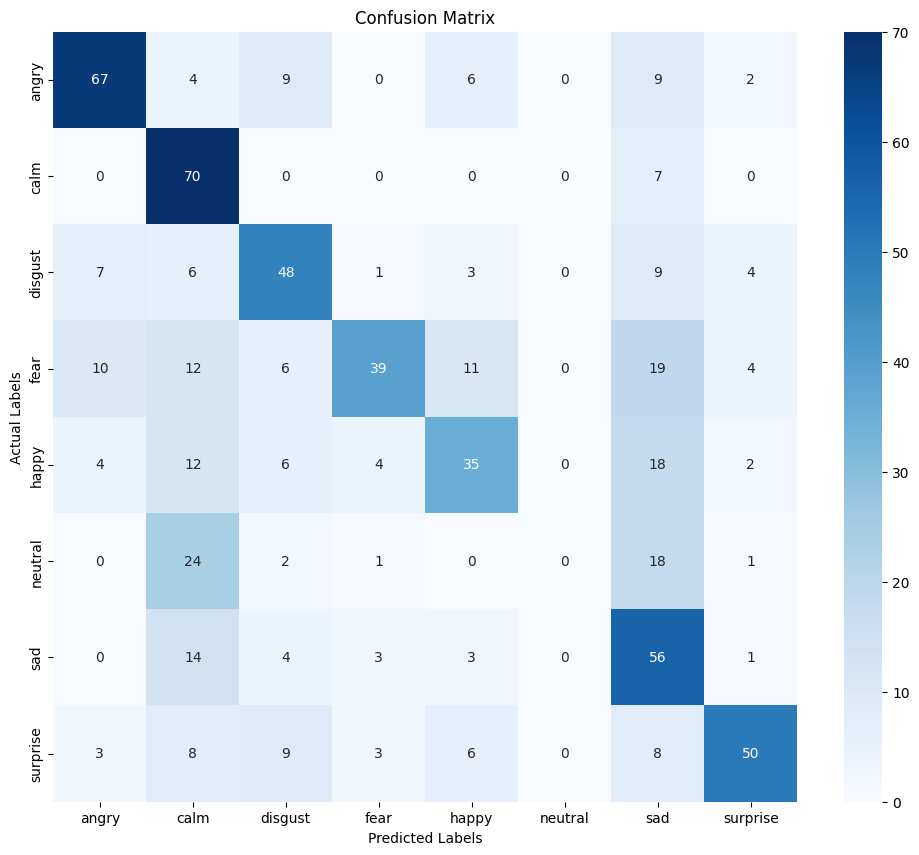

In [17]:
# ------------------------------ Valutazione del modello ------------------------
test_loader = DataLoader(TensorDataset(torch.tensor(x_test).float(), torch.tensor(np.argmax(y_test, axis=1)).long()), batch_size=64, shuffle=False)

correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy of the model on test data: {accuracy}%")

#-------------------------------------------------------------
import matplotlib.pyplot as plt

def plot_loss(train_losses, val_losses):
    """
    Plots training and validation loss.

    Parameters:
    train_losses (list): List of training losses.
    val_losses (list): List of validation losses.
    """
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label="Training Loss", color="blue")
    plt.plot(epochs, val_losses, label="Validation Loss", color="orange")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_accuracy(train_accuracies, val_accuracies):
    """
    Plots training and validation accuracy.

    Parameters:
    train_accuracies (list): List of training accuracies.
    val_accuracies (list): List of validation accuracies.
    """
    epochs = range(1, len(train_accuracies) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_accuracies, label="Training Accuracy", color="blue")
    plt.plot(epochs, val_accuracies, label="Validation Accuracy", color="orange")
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid(True)
    plt.show()

# After training, you can call the functions like this:
plot_loss(train_losses, val_losses)
plot_accuracy(train_accuracies, val_accuracies)
#----------------------------------------------------------------
# ----------------------------- Matrice di confusione --------------------------
pred_test = []
true_test = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        pred_test.extend(predicted.cpu().numpy())
        true_test.extend(labels.cpu().numpy())

cm = confusion_matrix(true_test, pred_test)
plt.figure(figsize=(12, 10))

# Convert encoder.categories_ to a list of strings
categories = [str(c) for c in encoder.categories_[0]] #added this line

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()
